# Protein Synthesis Simulation

Load dataset:

In [1]:
from HumanGenomeDataset.load_dataset import load_dataset

data_df = load_dataset('dna_protein_coding_sequences')
data_df.head(2)

c:\Users\giuli\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


,ID,sequence,category
0,NM_001368254.1,GCTGAGCTGAGCTGGGGCGCAGCCGCCTGTCTGCACCGGCAGCACC...,NM
1,NM_001350977.1,TCCACAACTGAAACATCCACTTCTGAACACCATGTCCTACTACAGC...,NM


### Simulation

In [2]:
from src.simulation import ProteinSinthesisProcess

In [3]:
import random
random.seed(42)

In [4]:
SIM_TIME = 3600*3 # 3 hours
NUMBER_RESOURCES = 30
NUMBER_RNA_POLYMERASES = 5
NUMBER_RIBOSOMES = 2
URACIL_INITIAL_AMOUNT = random.randint(3e+4, 5e+4)
ADENINE_INITIAL_AMOUNT = random.randint(4e+4, 6e+4)
GUANINE_INITIAL_AMOUNT = random.randint(3e+4, 5e+4)
CYTOSINE_INITIAL_AMOUNT = random.randint(3e+4, 5e+4)
RANDOM_SEED = 42

In [5]:
protein_synthesis_process = ProteinSinthesisProcess(
    dna_sequences_df=data_df,
    number_resources=NUMBER_RESOURCES,
    number_rna_polymerases=NUMBER_RNA_POLYMERASES, 
    number_ribosomes=NUMBER_RIBOSOMES,
    uracil_initial_amount=URACIL_INITIAL_AMOUNT,
    adenine_initial_amount=ADENINE_INITIAL_AMOUNT,
    guanine_initial_amount=GUANINE_INITIAL_AMOUNT,
    cytosine_initial_amount=CYTOSINE_INITIAL_AMOUNT,
    random_seed=RANDOM_SEED,
    verbose=False
    )

Simulation environment initialized, time unit: 0.0001 second.


In [6]:
print(protein_synthesis_process)

Protein Sinthesis Process:
185310 dna sequences to synthesize,
30 resources available,
5 RNA polymerases,
2 ribosomes,
33648 uracil bases,
40819 adenine bases,
39012 guanine bases,
38024 cytosine bases.


Start simulation:

In [7]:
protein_synthesis_process.run(simulation_time=SIM_TIME) # run the simulation

Simulation started
End simulation: 120 proteins synthesized from 66 DNA sequences.


In [8]:
protein_synthesis_process.save_process() # save the process

Process saved.


### Results

In [9]:
import pandas as pd
results_path = 'results/results.csv'

results_df = pd.read_csv(results_path, index_col=0)

In [10]:
print('Number of DNA sequence traslated:', results_df[results_df['mrna_sequences'].notna()].shape[0])
print('Number of DNA sequence not traslated:', results_df[results_df['protein_synthesized']==False].shape[0])

Number of DNA sequence traslated: 58
Number of DNA sequence not traslated: 8


In [11]:
results_df[results_df['mrna_sequences'].notna()][[
    'polypeptides_chains', 'number_of_proteins_synthesized', 'length_proteins', 'number_different_proteins']]

,polypeptides_chains,number_of_proteins_synthesized,length_proteins,number_different_proteins
4338,['NH2-HRPGGPSEKSREWEALERTEPPREGVWGKNRESREETPTQ...,1,[61],1.0
4588,"[None, None, None]",3,[],0.0
4652,['NH2-AESSRDQRWVSTNRIDSGSLGPNFLINCSLLHRVSMGRVF...,5,"[40, 40, 40, 40, 40]",1.0
6911,['NH2-SRSVAHRRMAAWKPPRGPKGEPRGDSSGHKGARPKPRFPR...,1,[117],1.0
7339,"['NH2-DREKKKDEKNEKEDEKHQ-COOH', 'NH2-DREKKKDEK...",2,"[18, 18]",1.0
8495,['NH2-PPTPGPTAWDPPSRTTRMWTSFTGPSVVGATPRSSGADLL...,1,[106],1.0
8950,['NH2-TSTIIFLGSTNRVSTFRINV-COOH'],1,[20],1.0
10172,[None],1,[],0.0
12155,"['NH2-RRTRSRLAKR-COOH', 'NH2-RRTRSRLAKR-COOH']",2,"[10, 10]",1.0
15425,['NH2-NPPLTVKLVKSFECRRAGLRRKRL-COOH'],1,[24],1.0


In [12]:
results_df[results_df['mrna_sequences'].notna()][
    ['request_start_process_time', 'start_process_time', 'end_process_time',
    'number_different_proteins', 'number_of_proteins_synthesized']
    ].describe()

,request_start_process_time,start_process_time,end_process_time,number_different_proteins,number_of_proteins_synthesized
count,58.000000,58.000000,58.000000,58.000000,58.000000
mean,1668.617159,1668.617159,1940.959753,1.000000,2.068966
std,1116.523921,1116.523921,1085.669269,0.324443,1.485155
min,0.000000,0.000000,131.351900,0.000000,1.000000
25%,667.986125,667.986125,1189.447400,1.000000,1.000000
50%,1651.087500,1651.087500,1830.400950,1.000000,1.500000
75%,2603.394025,2603.394025,2792.319250,1.000000,3.000000
max,3891.965100,3891.965100,4013.061800,2.000000,8.000000


In [13]:
"""
statistiche su: (sono liste di valori)
'start_transcription_time', 'start_translation_time',
'end_translation_time', 'length_proteins', 'protein_synthesized'
"""

"\nstatistiche su: (sono liste di valori)\n'start_transcription_time', 'start_translation_time',\n'end_translation_time', 'length_proteins', 'protein_synthesized'\n"

### Protein Length

In [14]:
from src.utils.plot_utils import *

In [15]:
results_df = pd.read_csv('results/results.csv', index_col=0)

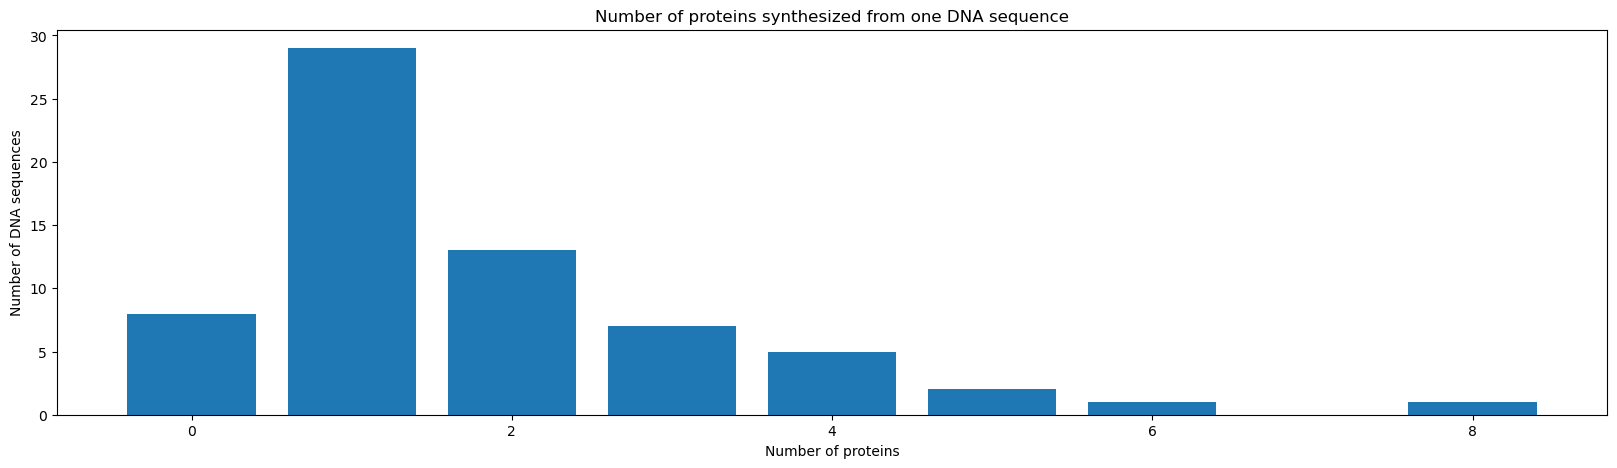

In [16]:
barplot_proteins_number(results_df)

In [17]:
def plot_proteins_number_over_time(results_df):
    number_of_proteins_synthesized = results_df[results_df['mrna_sequences'].notna()]['number_of_proteins_synthesized']
    time = results_df[results_df['mrna_sequences'].notna()]['end_process_time']
    time, number_of_proteins_synthesized = zip(*sorted(zip(time, number_of_proteins_synthesized)))

    plt.figure(figsize=(20, 5))
    plt.plot(time, number_of_proteins_synthesized, '.--')
    plt.title('Number of proteins synthesized over time')
    plt.xlabel('Time')
    plt.ylabel('Number of proteins')
    plt.show()

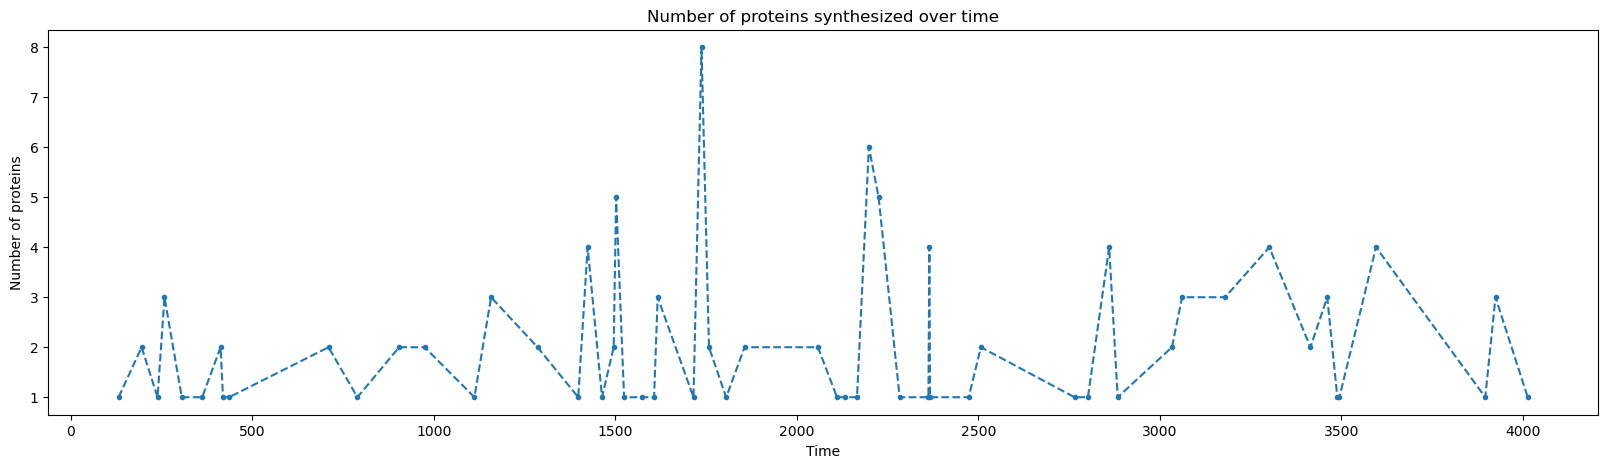

In [18]:
plot_proteins_number_over_time(results_df)

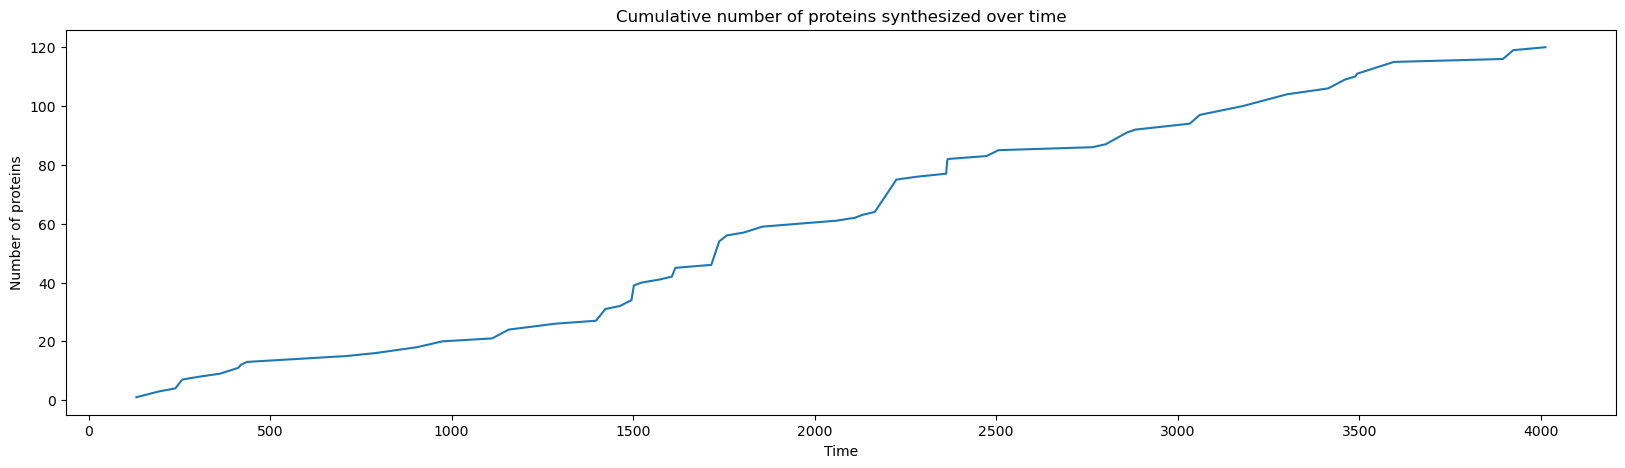

In [19]:
plot_cumulative_proteins_number_over_time(results_df)

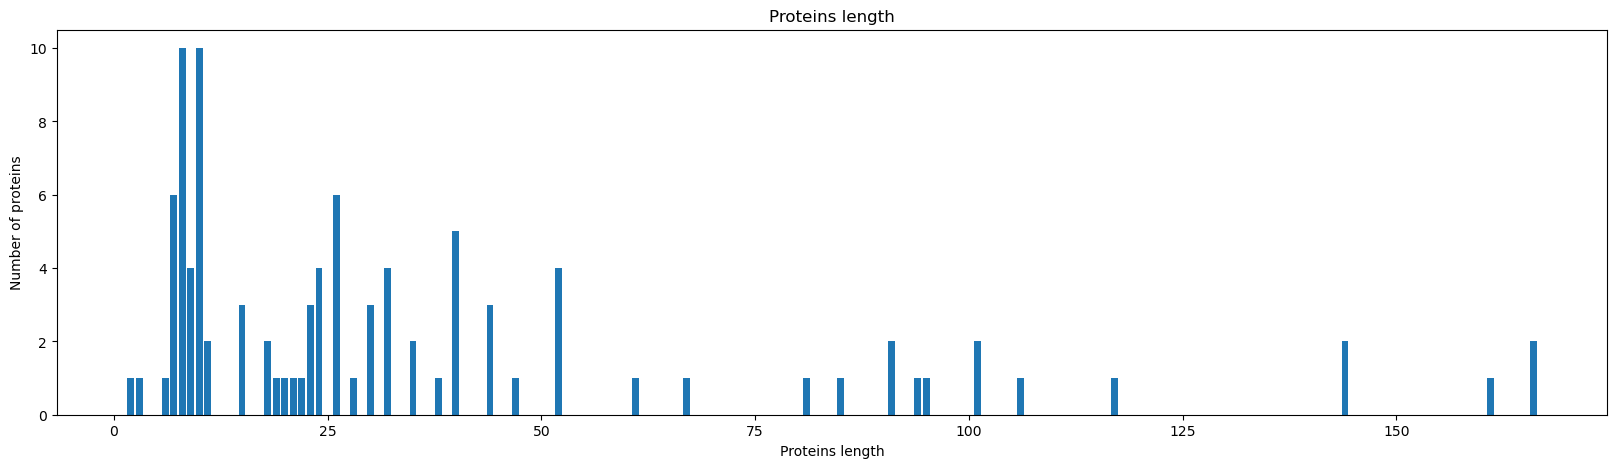

In [20]:
barplot_proteins_length(results_df)

### Nucleotides Level

In [21]:
import json

with open('results/nucleotides_history_uracil.json') as f:
    uracil_dict = json.load(f)

with open('results/nucleotides_history_adenine.json') as f:
    adenine_dict = json.load(f)

with open('results/nucleotides_history_guanine.json') as f:
    guanine_dict = json.load(f)

with open('results/nucleotides_history_cytosine.json') as f:
    cytosine_dict = json.load(f)

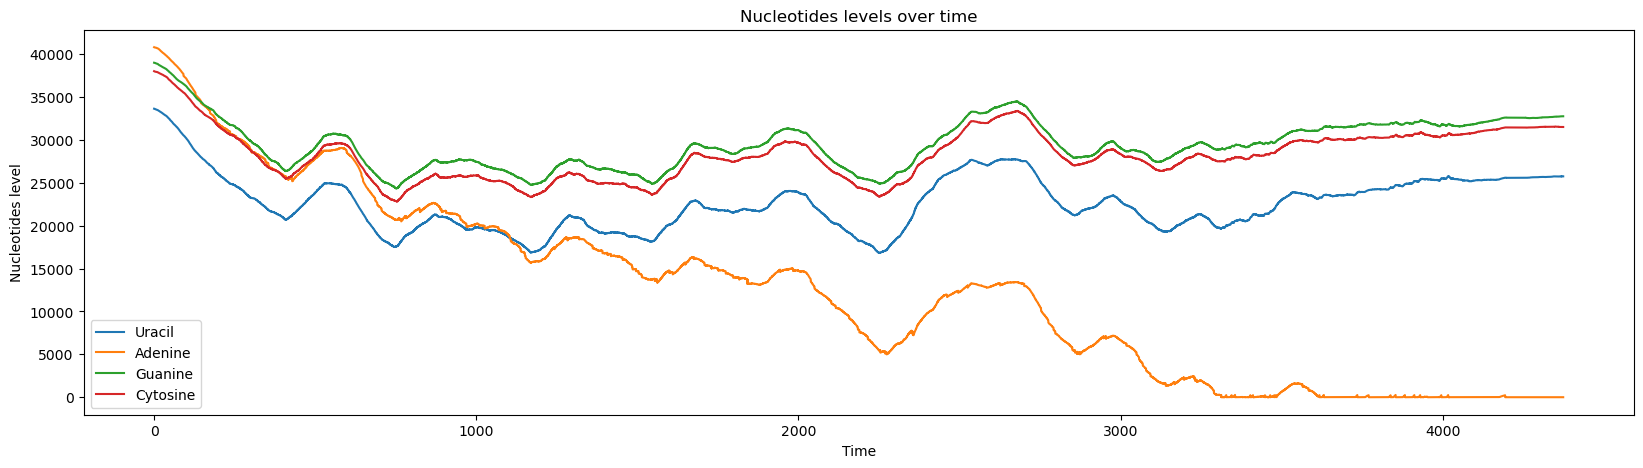

In [22]:
plot_nucleotide_level_over_time(
    uracil_dict, adenine_dict, guanine_dict, cytosine_dict)

In [23]:
"""
barplot_nucleotide_level_over_time(
    uracil_dict, adenine_dict, guanine_dict, cytosine_dict, time_unit=1)
"""

'\nbarplot_nucleotide_level_over_time(\n    uracil_dict, adenine_dict, guanine_dict, cytosine_dict, time_unit=1)\n'

### RNA Polymerase

In [24]:
with open('results/rna_polymerase_history.json') as f:
    rna_polymerase_dict = json.load(f)

In [25]:
rna_polymerase_df = dict_to_dataframe(rna_polymerase_dict)

In [26]:
rna_polymerase_df.describe() # values in seconds

,queue,request_time,available_time,wait_time,end_time,usage_time
count,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000
mean,0.602941,1896.922713,1911.431986,9.166490,2039.963674,28.275610
std,0.888439,1134.504327,1131.026544,16.503537,1138.702759,25.210654
min,0.000000,0.000000,0.000000,0.000000,92.133100,0.272300
25%,0.000000,907.403425,942.994575,0.000000,1110.360150,10.207900
50%,0.000000,1834.254150,1834.254150,0.000000,1970.314150,21.502050
75%,1.000000,2958.498400,2958.498400,11.613575,3070.326550,39.662975
max,4.000000,3852.326700,3894.977000,68.523500,4206.531700,176.892100


### Ribosome

In [27]:
with open('results/ribosome_history.json') as f:
    ribosome_dict = json.load(f)

In [28]:
ribosome_df = dict_to_dataframe(ribosome_dict)

In [29]:
ribosome_df.describe()

,queue,request_time,available_time,wait_time,end_time,usage_time
count,136.0,136.000000,136.000000,136.0,136.000000,136.000000
mean,0.0,2039.963674,2039.963674,0.0,2041.483527,1.405841
std,0.0,1138.702759,1138.702759,0.0,1138.387819,1.659808
min,0.0,92.133100,92.133100,0.0,93.333100,0.000000
25%,0.0,1110.360150,1110.360150,0.0,1112.172650,0.400000
50%,0.0,1970.314150,1970.314150,0.0,1971.689150,0.825000
75%,0.0,3070.326550,3070.326550,0.0,3071.639050,1.750000
max,0.0,4206.531700,4206.531700,0.0,4206.581700,8.300000


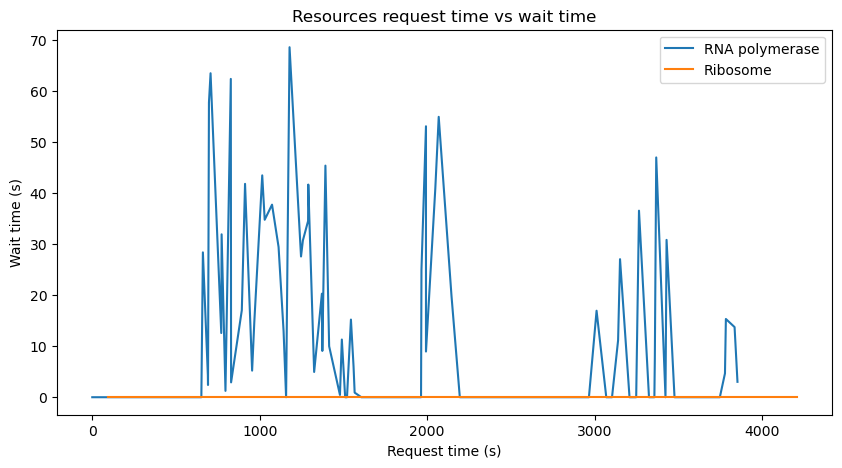

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(rna_polymerase_df['request_time'], rna_polymerase_df['wait_time'], label='RNA polymerase')
plt.plot(ribosome_df['request_time'], ribosome_df['wait_time'], label='Ribosome')
plt.title('Resources request time vs wait time')
plt.xlabel('Request time (s)')
plt.ylabel('Wait time (s)')
plt.legend()
plt.show()